<a href="https://colab.research.google.com/github/heroza/vit/blob/main/vit%20on%20ham10000.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install split-folders
!pip install --quiet vit-keras
!pip install coremltools

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 32.4 MB/s eta 0:00:00


In [3]:
import pandas as pd
train_df = pd.read_csv('/content/drive/MyDrive/PHD/Datasets/isic2017/ISIC-2017_Training_Part3_GroundTruth.csv')
test_df=pd.read_csv('/content/drive/MyDrive/PHD/Datasets/isic2017/ISIC-2017_Test_v2_Part3_GroundTruth.csv')

In [4]:
meta_train_df = pd.read_csv('/content/drive/MyDrive/PHD/Datasets/isic2017/ISIC-2017_Training_Data/ISIC-2017_Training_Data/ISIC-2017_Training_Data_metadata.csv')
meta_test_df=pd.read_csv('/content/drive/MyDrive/PHD/Datasets/isic2017/ISIC-2017_Test_v2_Data/ISIC-2017_Test_v2_Data/ISIC-2017_Test_v2_Data_metadata.csv')

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image
np.random.seed(123)
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix
import itertools

import pandas as pd
import numpy as np
import keras
from keras import backend as K

import tensorflow
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

import os

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import itertools
import shutil
import matplotlib.pyplot as plt

In [6]:
os.listdir('/content')

['.config', 'drive', 'sample_data']

In [7]:
base_dir = 'base_dir'
#os.mkdir(base_dir)

train_dir = os.path.join(base_dir, 'train_dir')
#os.mkdir(train_dir)

val_dir = os.path.join(base_dir, 'val_dir')
#os.mkdir(val_dir)

# create new folders inside train_dir
sb = os.path.join(train_dir, 'seb')
#os.mkdir(sb)
mel = os.path.join(train_dir, 'combined')
#os.mkdir(mel)

In [8]:
base_dir = 'base_dir'
os.mkdir(base_dir)

train_dir = os.path.join(base_dir, 'train_dir')
os.mkdir(train_dir)

val_dir = os.path.join(base_dir, 'val_dir')
os.mkdir(val_dir)

# create new folders inside train_dir
sb = os.path.join(train_dir, 'seb')
os.mkdir(sb)
mel = os.path.join(train_dir, 'combined')
os.mkdir(mel)

In [9]:
# create new folders inside val_dir
sb = os.path.join(val_dir, 'seb')
os.mkdir(sb)
mel = os.path.join(val_dir, 'combined')
os.mkdir(mel)

In [10]:
train_df

,image_id,melanoma,seborrheic_keratosis
0,ISIC_0000000,0.0,0.0
1,ISIC_0000001,0.0,0.0
2,ISIC_0000002,1.0,0.0
3,ISIC_0000003,0.0,0.0
4,ISIC_0000004,1.0,0.0
...,...,...,...
1995,ISIC_0015220,0.0,1.0
1996,ISIC_0015233,0.0,1.0
1997,ISIC_0015260,0.0,1.0
1998,ISIC_0015284,1.0,0.0


In [11]:
# base_skin_dir = os.path.join('..', 'content')
base_skin_dir = '/content/drive/MyDrive/PHD/Datasets/isic2017'

imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(base_skin_dir, '*', '*', '*.jpg'))}

In [12]:
train_df['path'] = train_df['image_id'].map(imageid_path_dict.get)

In [13]:
test_df['path'] = test_df['image_id'].map(imageid_path_dict.get)

In [14]:
train_df

,image_id,melanoma,seborrheic_keratosis,path
0,ISIC_0000000,0.0,0.0,/content/drive/MyDrive/PHD/Datasets/isic2017/I...
1,ISIC_0000001,0.0,0.0,/content/drive/MyDrive/PHD/Datasets/isic2017/I...
2,ISIC_0000002,1.0,0.0,/content/drive/MyDrive/PHD/Datasets/isic2017/I...
3,ISIC_0000003,0.0,0.0,/content/drive/MyDrive/PHD/Datasets/isic2017/I...
4,ISIC_0000004,1.0,0.0,/content/drive/MyDrive/PHD/Datasets/isic2017/I...
...,...,...,...,...
1995,ISIC_0015220,0.0,1.0,/content/drive/MyDrive/PHD/Datasets/isic2017/I...
1996,ISIC_0015233,0.0,1.0,/content/drive/MyDrive/PHD/Datasets/isic2017/I...
1997,ISIC_0015260,0.0,1.0,/content/drive/MyDrive/PHD/Datasets/isic2017/I...
1998,ISIC_0015284,1.0,0.0,/content/drive/MyDrive/PHD/Datasets/isic2017/I...


In [15]:
train_df.isnull().sum()


image_id                0
melanoma                0
seborrheic_keratosis    0
path                    0
dtype: int64

In [16]:
def add_jpg(x):
    x=x+".jpg"
    return x

In [17]:
train_df['new_image_id']=train_df['image_id'].apply(add_jpg)
test_df['new_image_id']=test_df['image_id'].apply(add_jpg)

In [18]:
train_df

,image_id,melanoma,seborrheic_keratosis,path,new_image_id
0,ISIC_0000000,0.0,0.0,/content/drive/MyDrive/PHD/Datasets/isic2017/I...,ISIC_0000000.jpg
1,ISIC_0000001,0.0,0.0,/content/drive/MyDrive/PHD/Datasets/isic2017/I...,ISIC_0000001.jpg
2,ISIC_0000002,1.0,0.0,/content/drive/MyDrive/PHD/Datasets/isic2017/I...,ISIC_0000002.jpg
3,ISIC_0000003,0.0,0.0,/content/drive/MyDrive/PHD/Datasets/isic2017/I...,ISIC_0000003.jpg
4,ISIC_0000004,1.0,0.0,/content/drive/MyDrive/PHD/Datasets/isic2017/I...,ISIC_0000004.jpg
...,...,...,...,...,...
1995,ISIC_0015220,0.0,1.0,/content/drive/MyDrive/PHD/Datasets/isic2017/I...,ISIC_0015220.jpg
1996,ISIC_0015233,0.0,1.0,/content/drive/MyDrive/PHD/Datasets/isic2017/I...,ISIC_0015233.jpg
1997,ISIC_0015260,0.0,1.0,/content/drive/MyDrive/PHD/Datasets/isic2017/I...,ISIC_0015260.jpg
1998,ISIC_0015284,1.0,0.0,/content/drive/MyDrive/PHD/Datasets/isic2017/I...,ISIC_0015284.jpg


In [19]:
def add_label1(x):
    if(x==0.0):
      return 'no'
    else:
      return 'mel'

In [20]:
def add_label2(x):
    if(x==0.0):
      return 'no'
    else:
      return 'seb'

In [21]:
def add_label3(x):
    if(x=='nono'):
      return 0
    elif(x=='melno'):
      return 2
    else:
      return 1

In [22]:
train_df['id']=train_df['melanoma'].apply(add_label1)+train_df['seborrheic_keratosis'].apply(add_label2)
test_df['id']=test_df['melanoma'].apply(add_label1)+test_df['seborrheic_keratosis'].apply(add_label2)

In [23]:
train_df

,image_id,melanoma,seborrheic_keratosis,path,new_image_id,id
0,ISIC_0000000,0.0,0.0,/content/drive/MyDrive/PHD/Datasets/isic2017/I...,ISIC_0000000.jpg,nono
1,ISIC_0000001,0.0,0.0,/content/drive/MyDrive/PHD/Datasets/isic2017/I...,ISIC_0000001.jpg,nono
2,ISIC_0000002,1.0,0.0,/content/drive/MyDrive/PHD/Datasets/isic2017/I...,ISIC_0000002.jpg,melno
3,ISIC_0000003,0.0,0.0,/content/drive/MyDrive/PHD/Datasets/isic2017/I...,ISIC_0000003.jpg,nono
4,ISIC_0000004,1.0,0.0,/content/drive/MyDrive/PHD/Datasets/isic2017/I...,ISIC_0000004.jpg,melno
...,...,...,...,...,...,...
1995,ISIC_0015220,0.0,1.0,/content/drive/MyDrive/PHD/Datasets/isic2017/I...,ISIC_0015220.jpg,noseb
1996,ISIC_0015233,0.0,1.0,/content/drive/MyDrive/PHD/Datasets/isic2017/I...,ISIC_0015233.jpg,noseb
1997,ISIC_0015260,0.0,1.0,/content/drive/MyDrive/PHD/Datasets/isic2017/I...,ISIC_0015260.jpg,noseb
1998,ISIC_0015284,1.0,0.0,/content/drive/MyDrive/PHD/Datasets/isic2017/I...,ISIC_0015284.jpg,melno


In [24]:
train_df['label']=train_df['id'].apply(add_label3)
train_df

,image_id,melanoma,seborrheic_keratosis,path,new_image_id,id,label
0,ISIC_0000000,0.0,0.0,/content/drive/MyDrive/PHD/Datasets/isic2017/I...,ISIC_0000000.jpg,nono,0
1,ISIC_0000001,0.0,0.0,/content/drive/MyDrive/PHD/Datasets/isic2017/I...,ISIC_0000001.jpg,nono,0
2,ISIC_0000002,1.0,0.0,/content/drive/MyDrive/PHD/Datasets/isic2017/I...,ISIC_0000002.jpg,melno,2
3,ISIC_0000003,0.0,0.0,/content/drive/MyDrive/PHD/Datasets/isic2017/I...,ISIC_0000003.jpg,nono,0
4,ISIC_0000004,1.0,0.0,/content/drive/MyDrive/PHD/Datasets/isic2017/I...,ISIC_0000004.jpg,melno,2
...,...,...,...,...,...,...,...
1995,ISIC_0015220,0.0,1.0,/content/drive/MyDrive/PHD/Datasets/isic2017/I...,ISIC_0015220.jpg,noseb,1
1996,ISIC_0015233,0.0,1.0,/content/drive/MyDrive/PHD/Datasets/isic2017/I...,ISIC_0015233.jpg,noseb,1
1997,ISIC_0015260,0.0,1.0,/content/drive/MyDrive/PHD/Datasets/isic2017/I...,ISIC_0015260.jpg,noseb,1
1998,ISIC_0015284,1.0,0.0,/content/drive/MyDrive/PHD/Datasets/isic2017/I...,ISIC_0015284.jpg,melno,2


In [25]:
test_df['label']=test_df['id'].apply(add_label3)

In [26]:
lesion_type_dict = {
    'nono': 'Nevus',
    'melno': 'Melanoma',
    'noseb': 'seborrheic_keratosis',
}

In [27]:
cell_type_dict = {
    'Nevus': 'combined',
    'Melanoma': 'combined',
    'seborrheic_keratosis': 'seb',
}

In [28]:
train_df['cell_type'] = train_df['id'].map(lesion_type_dict.get)

In [29]:
test_df['cell_type'] = test_df['id'].map(lesion_type_dict.get)

In [30]:
train_df['dx'] = train_df['cell_type'].map(cell_type_dict.get)
test_df['dx'] = test_df['cell_type'].map(cell_type_dict.get)

In [31]:
train_df.drop(['melanoma','seborrheic_keratosis', 'id'], axis=1)

,image_id,path,new_image_id,label,cell_type,dx
0,ISIC_0000000,/content/drive/MyDrive/PHD/Datasets/isic2017/I...,ISIC_0000000.jpg,0,Nevus,combined
1,ISIC_0000001,/content/drive/MyDrive/PHD/Datasets/isic2017/I...,ISIC_0000001.jpg,0,Nevus,combined
2,ISIC_0000002,/content/drive/MyDrive/PHD/Datasets/isic2017/I...,ISIC_0000002.jpg,2,Melanoma,combined
3,ISIC_0000003,/content/drive/MyDrive/PHD/Datasets/isic2017/I...,ISIC_0000003.jpg,0,Nevus,combined
4,ISIC_0000004,/content/drive/MyDrive/PHD/Datasets/isic2017/I...,ISIC_0000004.jpg,2,Melanoma,combined
...,...,...,...,...,...,...
1995,ISIC_0015220,/content/drive/MyDrive/PHD/Datasets/isic2017/I...,ISIC_0015220.jpg,1,seborrheic_keratosis,seb
1996,ISIC_0015233,/content/drive/MyDrive/PHD/Datasets/isic2017/I...,ISIC_0015233.jpg,1,seborrheic_keratosis,seb
1997,ISIC_0015260,/content/drive/MyDrive/PHD/Datasets/isic2017/I...,ISIC_0015260.jpg,1,seborrheic_keratosis,seb
1998,ISIC_0015284,/content/drive/MyDrive/PHD/Datasets/isic2017/I...,ISIC_0015284.jpg,2,Melanoma,combined


In [32]:
test_df.drop(['melanoma','seborrheic_keratosis', 'id'], axis=1)

,image_id,path,new_image_id,label,cell_type,dx
0,ISIC_0012086,/content/drive/MyDrive/PHD/Datasets/isic2017/I...,ISIC_0012086.jpg,1,seborrheic_keratosis,seb
1,ISIC_0012092,/content/drive/MyDrive/PHD/Datasets/isic2017/I...,ISIC_0012092.jpg,0,Nevus,combined
2,ISIC_0012095,/content/drive/MyDrive/PHD/Datasets/isic2017/I...,ISIC_0012095.jpg,0,Nevus,combined
3,ISIC_0012134,/content/drive/MyDrive/PHD/Datasets/isic2017/I...,ISIC_0012134.jpg,1,seborrheic_keratosis,seb
4,ISIC_0012136,/content/drive/MyDrive/PHD/Datasets/isic2017/I...,ISIC_0012136.jpg,1,seborrheic_keratosis,seb
...,...,...,...,...,...,...
595,ISIC_0016068,/content/drive/MyDrive/PHD/Datasets/isic2017/I...,ISIC_0016068.jpg,0,Nevus,combined
596,ISIC_0016069,/content/drive/MyDrive/PHD/Datasets/isic2017/I...,ISIC_0016069.jpg,0,Nevus,combined
597,ISIC_0016070,/content/drive/MyDrive/PHD/Datasets/isic2017/I...,ISIC_0016070.jpg,0,Nevus,combined
598,ISIC_0016071,/content/drive/MyDrive/PHD/Datasets/isic2017/I...,ISIC_0016071.jpg,0,Nevus,combined


Not able to run due computational limtation

In [33]:
#train_df['image'] = train_df['path'].map(lambda x: np.asarray(Image.open(x)))

In [34]:
train_df.isnull().sum()

image_id                0
melanoma                0
seborrheic_keratosis    0
path                    0
new_image_id            0
id                      0
label                   0
cell_type               0
dx                      0
dtype: int64

<Axes: >

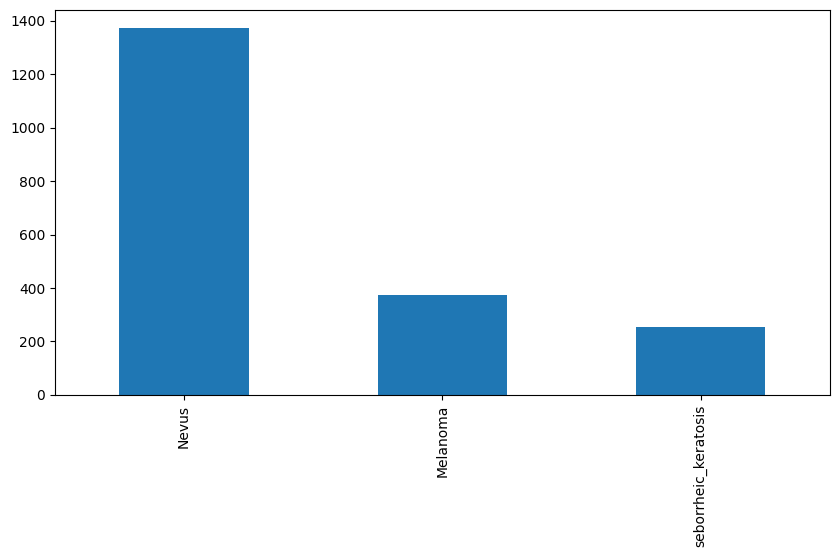

In [35]:
# Distribution of 7 classes
fig, ax1 = plt.subplots(1, 1, figsize= (10, 5))
train_df['cell_type'].value_counts().plot(kind='bar', ax=ax1)

In [36]:
train_df

,image_id,melanoma,seborrheic_keratosis,path,new_image_id,id,label,cell_type,dx
0,ISIC_0000000,0.0,0.0,/content/drive/MyDrive/PHD/Datasets/isic2017/I...,ISIC_0000000.jpg,nono,0,Nevus,combined
1,ISIC_0000001,0.0,0.0,/content/drive/MyDrive/PHD/Datasets/isic2017/I...,ISIC_0000001.jpg,nono,0,Nevus,combined
2,ISIC_0000002,1.0,0.0,/content/drive/MyDrive/PHD/Datasets/isic2017/I...,ISIC_0000002.jpg,melno,2,Melanoma,combined
3,ISIC_0000003,0.0,0.0,/content/drive/MyDrive/PHD/Datasets/isic2017/I...,ISIC_0000003.jpg,nono,0,Nevus,combined
4,ISIC_0000004,1.0,0.0,/content/drive/MyDrive/PHD/Datasets/isic2017/I...,ISIC_0000004.jpg,melno,2,Melanoma,combined
...,...,...,...,...,...,...,...,...,...
1995,ISIC_0015220,0.0,1.0,/content/drive/MyDrive/PHD/Datasets/isic2017/I...,ISIC_0015220.jpg,noseb,1,seborrheic_keratosis,seb
1996,ISIC_0015233,0.0,1.0,/content/drive/MyDrive/PHD/Datasets/isic2017/I...,ISIC_0015233.jpg,noseb,1,seborrheic_keratosis,seb
1997,ISIC_0015260,0.0,1.0,/content/drive/MyDrive/PHD/Datasets/isic2017/I...,ISIC_0015260.jpg,noseb,1,seborrheic_keratosis,seb
1998,ISIC_0015284,1.0,0.0,/content/drive/MyDrive/PHD/Datasets/isic2017/I...,ISIC_0015284.jpg,melno,2,Melanoma,combined


In [37]:
merged_df = pd.merge(train_df, meta_train_df, on="image_id", how="left")

In [38]:
merged_test_df = pd.merge(test_df, meta_test_df, on="image_id", how="left")

In [39]:
merged_df = merged_df.drop(['melanoma','seborrheic_keratosis', 'id'], axis=1)

In [40]:
merged_test_df = merged_test_df.drop(['melanoma','seborrheic_keratosis', 'id'], axis=1)

In [41]:
merged_test_df

,image_id,path,new_image_id,label,cell_type,dx,age_approximate,sex
0,ISIC_0012086,/content/drive/MyDrive/PHD/Datasets/isic2017/I...,ISIC_0012086.jpg,1,seborrheic_keratosis,seb,30,male
1,ISIC_0012092,/content/drive/MyDrive/PHD/Datasets/isic2017/I...,ISIC_0012092.jpg,0,Nevus,combined,40,male
2,ISIC_0012095,/content/drive/MyDrive/PHD/Datasets/isic2017/I...,ISIC_0012095.jpg,0,Nevus,combined,25,male
3,ISIC_0012134,/content/drive/MyDrive/PHD/Datasets/isic2017/I...,ISIC_0012134.jpg,1,seborrheic_keratosis,seb,75,female
4,ISIC_0012136,/content/drive/MyDrive/PHD/Datasets/isic2017/I...,ISIC_0012136.jpg,1,seborrheic_keratosis,seb,70,male
...,...,...,...,...,...,...,...,...
595,ISIC_0016068,/content/drive/MyDrive/PHD/Datasets/isic2017/I...,ISIC_0016068.jpg,0,Nevus,combined,70,male
596,ISIC_0016069,/content/drive/MyDrive/PHD/Datasets/isic2017/I...,ISIC_0016069.jpg,0,Nevus,combined,30,female
597,ISIC_0016070,/content/drive/MyDrive/PHD/Datasets/isic2017/I...,ISIC_0016070.jpg,0,Nevus,combined,65,male
598,ISIC_0016071,/content/drive/MyDrive/PHD/Datasets/isic2017/I...,ISIC_0016071.jpg,0,Nevus,combined,60,female


In [42]:
merged_df

,image_id,path,new_image_id,label,cell_type,dx,age_approximate,sex
0,ISIC_0000000,/content/drive/MyDrive/PHD/Datasets/isic2017/I...,ISIC_0000000.jpg,0,Nevus,combined,55,female
1,ISIC_0000001,/content/drive/MyDrive/PHD/Datasets/isic2017/I...,ISIC_0000001.jpg,0,Nevus,combined,30,female
2,ISIC_0000002,/content/drive/MyDrive/PHD/Datasets/isic2017/I...,ISIC_0000002.jpg,2,Melanoma,combined,60,female
3,ISIC_0000003,/content/drive/MyDrive/PHD/Datasets/isic2017/I...,ISIC_0000003.jpg,0,Nevus,combined,30,male
4,ISIC_0000004,/content/drive/MyDrive/PHD/Datasets/isic2017/I...,ISIC_0000004.jpg,2,Melanoma,combined,80,male
...,...,...,...,...,...,...,...,...
1995,ISIC_0015220,/content/drive/MyDrive/PHD/Datasets/isic2017/I...,ISIC_0015220.jpg,1,seborrheic_keratosis,seb,75,male
1996,ISIC_0015233,/content/drive/MyDrive/PHD/Datasets/isic2017/I...,ISIC_0015233.jpg,1,seborrheic_keratosis,seb,60,male
1997,ISIC_0015260,/content/drive/MyDrive/PHD/Datasets/isic2017/I...,ISIC_0015260.jpg,1,seborrheic_keratosis,seb,55,female
1998,ISIC_0015284,/content/drive/MyDrive/PHD/Datasets/isic2017/I...,ISIC_0015284.jpg,2,Melanoma,combined,75,male


<Axes: >

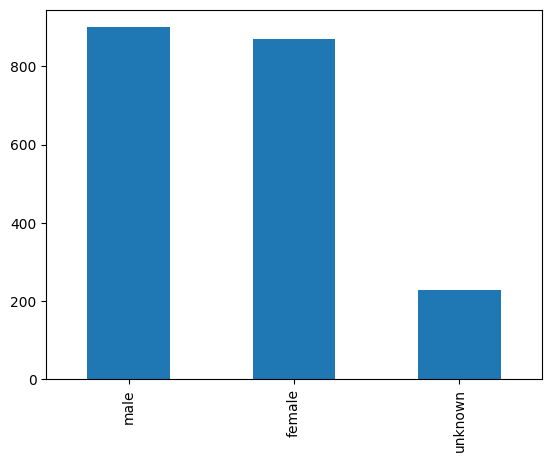

In [43]:
merged_df['sex'].value_counts().plot(kind='bar')

In [44]:
# Set the image_id as the index in df_data
#merged_df.set_index('image_id', inplace=True)

In [45]:
# Get a list of images in each of the two folders
folder_1 = os.listdir('/content/drive/MyDrive/PHD/Datasets/isic2017/ISIC-2017_Training_Data/ISIC-2017_Training_Data')
folder_2 = os.listdir('/content/drive/MyDrive/PHD/Datasets/isic2017/ISIC-2017_Test_v2_Data/ISIC-2017_Test_v2_Data')

# Get a list of train and val images
train_list = list(merged_df['image_id'])
val_list = list(merged_test_df['image_id'])

merged_df.set_index('image_id', inplace=True)
merged_test_df.set_index('image_id', inplace=True)


# Transfer the train images

for image in train_list:

    fname = image + '.jpg'
    label = merged_df.loc[image,'dx']

    if fname in folder_1:
        # source path to image
        src = os.path.join('/content/drive/MyDrive/PHD/Datasets/isic2017/ISIC-2017_Training_Data/ISIC-2017_Training_Data', fname)
        # destination path to image
        dst = os.path.join(train_dir, label, fname)
        # copy the image from the source to the destination
        shutil.copyfile(src, dst)

for image in val_list:

    fname = image + '.jpg'
    label = merged_test_df.loc[image,'dx']

    if fname in folder_2:
        # source path to image
        src = os.path.join('/content/drive/MyDrive/PHD/Datasets/isic2017/ISIC-2017_Test_v2_Data/ISIC-2017_Test_v2_Data', fname)
        # destination path to image
        dst = os.path.join(val_dir, label, fname)
        # copy the image from the source to the destination
        shutil.copyfile(src, dst)

In [46]:
print(len(os.listdir('base_dir/train_dir/seb')))
print(len(os.listdir('base_dir/train_dir/combined')))

254
1746


In [47]:
# check how many val images we have in each folder

print(len(os.listdir('base_dir/val_dir/seb')))
print(len(os.listdir('base_dir/val_dir/combined')))

90
510


In [48]:
# Copy the train images into aug_dir
# note that we are not augmenting class 'nv'
class_list = ['seb','combined']

for item in class_list:

    # We are creating temporary directories here because we delete these directories later
    # create a base dir
    aug_dir = 'aug_dir'
    os.mkdir(aug_dir)
    # create a dir within the base dir to store images of the same class
    img_dir = os.path.join(aug_dir, 'img_dir')
    os.mkdir(img_dir)

    # Choose a class
    img_class = item

    # list all images in that directory
    img_list = os.listdir('base_dir/train_dir/' + img_class)

    # Copy images from the class train dir to the img_dir e.g. class 'mel'
    for fname in img_list:
            # source path to image
            src = os.path.join('base_dir/train_dir/' + img_class, fname)
            # destination path to image
            dst = os.path.join(img_dir, fname)
            # copy the image from the source to the destination
            shutil.copyfile(src, dst)


    # point to a dir containing the images and not to the images themselves
    path = aug_dir
    save_path = 'base_dir/train_dir/' + img_class

    # Create a data generator
    datagen = ImageDataGenerator(
        rotation_range=180,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        vertical_flip=True,
        brightness_range=(0.9,1.1),
        fill_mode='nearest')

    batch_size = 32

    aug_datagen = datagen.flow_from_directory(path,
                                           save_to_dir=save_path,
                                           save_format='jpg',
                                                    target_size=(224,224),
                                                    batch_size=batch_size)



    # Generate the augmented images and add them to the training folders

    ###########

    num_aug_images_wanted = 2500 # total number of images we want to have in each class

    ###########

    num_files = len(os.listdir(img_dir))
    num_batches = int(np.ceil((num_aug_images_wanted-num_files)/batch_size))

    # run the generator and create about 6000 augmented images
    for i in range(0,num_batches):

        imgs, labels = next(aug_datagen)

    # delete temporary directory with the raw image files
    shutil.rmtree('aug_dir')

Found 254 images belonging to 1 classes.
Found 1746 images belonging to 1 classes.


In [49]:
def plots(ims, figsize=(12, 6), rows=5, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if ims.shape[-1] != 3:
            ims = ims.transpose((0, 2, 3, 1))
    num_images = len(ims)
    cols = num_images // rows if num_images % rows == 0 else num_images // rows + 1
    if rows * cols < num_images:
        cols += 1
    f = plt.figure(figsize=figsize)
    for i in range(num_images):
        sp = f.add_subplot(rows, cols, i + 1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')
        plt.show()

In [50]:
import pathlib

train_path = pathlib.Path("base_dir/train_dir/")
valid_path = pathlib.Path("base_dir/val_dir/")

image_count = len(list(train_path.glob('*/*.jpg')))

num_train_samples = len(merged_df)
num_val_samples = len(merged_test_df)
train_batch_size = 10
val_batch_size = 10
image_size = 224


image_count = len(list(train_path.glob("*/*.jpg")))
train_steps = np.ceil(num_train_samples / train_batch_size)
val_steps = np.ceil(num_val_samples / val_batch_size)

In [51]:
datagen = ImageDataGenerator(
    preprocessing_function= \
    tensorflow.keras.applications.mobilenet.preprocess_input)

train_batches = datagen.flow_from_directory(train_path,
                                            target_size=(image_size,image_size),
                                            batch_size=train_batch_size)

valid_batches = datagen.flow_from_directory(valid_path,
                                            target_size=(image_size,image_size),
                                            batch_size=val_batch_size)

# Note: shuffle=False causes the test dataset to not be shuffled
test_batches = datagen.flow_from_directory(valid_path,
                                            target_size=(image_size,image_size),
                                            batch_size=1,
                                            shuffle=False)


Found 5024 images belonging to 2 classes.
Found 600 images belonging to 2 classes.
Found 600 images belonging to 2 classes.


In [52]:
!pip install tensorflow_addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.0/591.0 kB 19.5 MB/s eta 0:00:00


In [53]:
# blocks output in Colab 💄
%%capture

! pip install datasets transformers

In [54]:
from datasets import load_dataset

ds = load_dataset("imagefolder", data_dir="base_dir")

Resolving data files:   0%|          | 0/5024 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/600 [00:00<?, ?it/s]

Extracting data files: 0it [00:00, ?it/s]

Extracting data files: 0it [00:00, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Dataset imagefolder downloaded and prepared to /root/.cache/huggingface/datasets/imagefolder/default-269fb9dcc98e03fb/0.0.0/37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

In [55]:
ds["train"][0]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1022x767 at 0x7F73F580C2B0>,
 'label': 0}

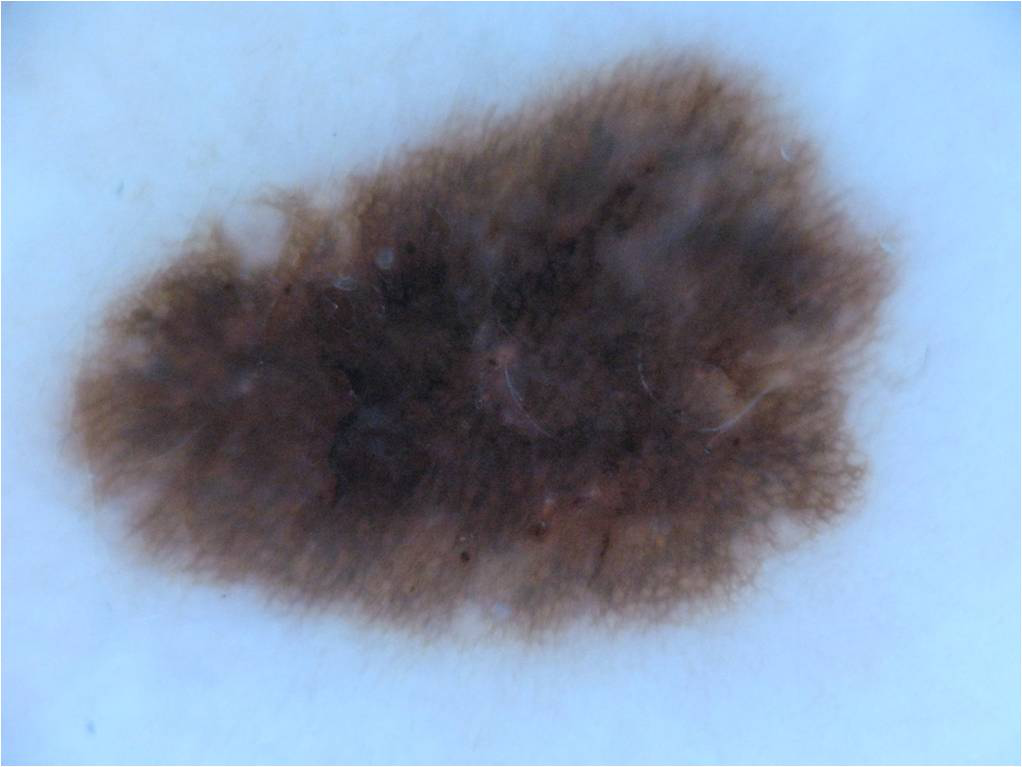

In [56]:
ds["train"][0]['image']

In [57]:
from transformers import ViTFeatureExtractor

model_name_or_path = 'google/vit-base-patch16-224-in21k'
feature_extractor = ViTFeatureExtractor.from_pretrained(model_name_or_path)


/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [58]:
#ds = load_dataset('beans')
#,,

def transform(example_batch):
    # Take a list of PIL images and turn them to pixel values
    inputs = feature_extractor([x for x in example_batch['image']], return_tensors='pt')

    # Don't forget to include the labels!
    inputs['labels'] = example_batch['label']
    return inputs


In [59]:
prepared_ds = ds.with_transform(transform)


In [60]:
import torch

def collate_fn(batch):
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
        'labels': torch.tensor([x['labels'] for x in batch])
    }


In [61]:
import numpy as np
from datasets import load_metric

metric = load_metric("accuracy")
def compute_metrics(p):
    return metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids)


<ipython-input-61-3044fb6e3895>:4: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("accuracy")


In [62]:
from transformers import ViTForImageClassification

labels = ds['train'].features['label'].names

model = ViTForImageClassification.from_pretrained(
    model_name_or_path,
    num_labels=len(labels),
    id2label={str(i): c for i, c in enumerate(labels)},
    label2id={c: str(i) for i, c in enumerate(labels)}
)


Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTForImageClassification: ['pooler.dense.bias', 'pooler.dense.weight']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [63]:
from transformers import TrainingArguments

training_args = TrainingArguments(
  output_dir="./vit-base-beans",
  per_device_train_batch_size=16,
  evaluation_strategy="steps",
  num_train_epochs=4,
  fp16=True,
  save_steps=100,
  eval_steps=100,
  logging_steps=10,
  learning_rate=2e-4,
  save_total_limit=2,
  remove_unused_columns=False,
  push_to_hub=False,
  report_to='tensorboard',
  load_best_model_at_end=True,
)


In [64]:
pip install accelerate -U

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [79]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    train_dataset=prepared_ds["train"],
    eval_dataset=prepared_ds["validation"],
    tokenizer=feature_extractor,
)


In [66]:
train_results = trainer.train()
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy
100,0.259600,0.308135,0.863333
200,0.347700,0.485001,0.795000
300,0.298600,0.353508,0.866667
400,0.124400,0.513409,0.796667
500,0.164800,0.270604,0.893333
600,0.140000,0.420346,0.818333
700,0.042800,0.373626,0.873333
800,0.046000,0.302637,0.888333


Step,Training Loss,Validation Loss,Accuracy
100,0.259600,0.308135,0.863333
200,0.347700,0.485001,0.795000
300,0.298600,0.353508,0.866667
400,0.124400,0.513409,0.796667
500,0.164800,0.270604,0.893333
600,0.140000,0.420346,0.818333
700,0.042800,0.373626,0.873333
800,0.046000,0.302637,0.888333
900,0.054900,0.608003,0.828333
1000,0.004100,0.400107,0.875000


***** train metrics *****
  epoch                    =          4.0
  total_flos               = 1450329109GF
  train_loss               =       0.1301
  train_runtime            =   2:10:46.26
  train_samples_per_second =        2.561
  train_steps_per_second   =         0.16


Evaluation

In [78]:
model = ViTForImageClassification.from_pretrained("./vit-base-beans/checkpoint-500")

In [80]:
predictions = trainer.predict(prepared_ds["validation"])
print(predictions.predictions.shape, predictions.label_ids.shape)

(600, 2) (600,)


In [81]:
import numpy as np

preds = np.argmax(predictions.predictions, axis=-1)

In [72]:
pip install evaluate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 6.1 MB/s eta 0:00:00


In [82]:
import evaluate

metric = evaluate.load("glue", "mrpc")
metric.compute(predictions=preds, references=predictions.label_ids)

{'accuracy': 0.8933333333333333, 'f1': 0.6}

In [75]:
from vit_keras import vit
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
import math

In [ ]:

vit_model = vit.vit_b16(
        image_size = 224,
        activation = 'softmax',
        pretrained = True,
        include_top = True,
        pretrained_top = False,
        classes = 2)

In [ ]:
processor = ViTImageProcessor.from_pretrained('facebook/dino-vitb16')
model = ViTModel.from_pretrained('facebook/dino-vitb16')

In [ ]:
model = vit_model

In [ ]:
model.summary()

In [ ]:
for layer in model.layers:
  print(layer.trainable)

In [ ]:
for layer in model.layers[0:-1]:
  layer.trainable = False
# model.layers[0:-1].trainable = False

for layer in model.layers:
  print(layer.trainable)

In [ ]:

model = tf.keras.Sequential([
        vit_model,
        # tf.keras.layers.Flatten(),
        # tf.keras.layers.BatchNormalization(),
        # tf.keras.layers.Dense(11, activation = tfa.activations.gelu),
        # tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(2, 'softmax')
    ],
    name = 'vision_transformer')

model.summary()

In [ ]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss',patience=3)

checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath = 'model.hdf5',
                                                  monitor = 'val_accuracy',
                                                  verbose = 1,
                                                  save_best_only = True,
                                                  save_weights_only = True,
                                                  mode = 'max')

def step_decay(epoch):
    initial_lrate = 0.00002
    drop = 0.1
    epochs_drop = 10.0
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lrate

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(step_decay, verbose=1)

In [ ]:
callbacks = [early_stopping, checkpointer, lr_scheduler]

In [ ]:
history = model.fit_generator(train_batches, steps_per_epoch=train_steps,
                              validation_data=valid_batches,
                              validation_steps=val_steps,
                              epochs=20,
                              callbacks=callbacks)

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

In [ ]:
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Model Accuracy: Training and Validation')
plt.legend(loc=0)
plt.figure()

In [ ]:
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation Loss')
plt.legend(loc=0)
plt.figure()


In [ ]:
from tensorflow.keras.models import Model
from keras import models

In [ ]:
model.load_weights(filepath = 'model.hdf5')

In [ ]:
model_test_performace = model.evaluate(test_batches)

In [ ]:
test_accuracy = model_test_performace[1]

print(f'Test accuracy: {round(test_accuracy*100, 2)}%')

In [ ]:
test_labels = test_batches.classes

In [ ]:
predictions = model.predict_generator(test_batches, steps=len(test_batches), verbose=1)

In [ ]:
predictions.shape

In [ ]:
test_labels = test_batches.classes

In [ ]:
test_batches.class_indices

In [ ]:
test_labels.shape

In [74]:
cm_plot_labels = ['combined', 'seb']

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [ ]:

cm = confusion_matrix(test_labels, predictions.argmax(axis=1))

In [ ]:
plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix')

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(test_labels, predictions.argmax(axis=1), target_names=cm_plot_labels))

In [83]:
from sklearn.metrics import classification_report
print(classification_report(preds, predictions.label_ids))#armax(axis=), target_names=cm_plot_labels))


              precision    recall  f1-score   support

           0       0.96      0.92      0.94       530
           1       0.53      0.69      0.60        70

    accuracy                           0.89       600
   macro avg       0.75      0.80      0.77       600
weighted avg       0.91      0.89      0.90       600



In [ ]:

from sklearn.metrics import roc_auc_score
from sklearn.metrics import  precision_score, recall_score, accuracy_score

In [ ]:
print("Precision: "+ str(precision_score(test_labels, predictions.argmax(axis=1), average='weighted')))
print("Recall: "+ str(recall_score(test_labels, predictions.argmax(axis=1), average='weighted')))

In [ ]:
from tensorflow.keras.utils import to_categorical
y_test = to_categorical(test_labels)
print("weighted Roc score: " + str(roc_auc_score(y_test,predictions,average='weighted')))

In [ ]:
from sklearn.metrics import confusion_matrix

cm1 = confusion_matrix(test_labels,predictions.argmax(axis=1))
print('Confusion Matrix : \n', cm1)

total1=sum(sum(cm1))
#####from confusion matrix calculate accuracy
accuracy1=(cm1[0,0]+cm1[1,1])/total1
print ('Accuracy : ', accuracy1)

sensitivity1 = cm1[0,0]/(cm1[0,0]+cm1[1,0])
print('Sensitivity : ', sensitivity1 )

specificity1 = cm1[1,1]/(cm1[1,1]+cm1[0,1])
print('Specificity : ', specificity1)

Freezing ViT B16 - Adam

In [ ]:
for layer in model.layers[2:4]:
  layer.trainable = False

for layer in model.layers:
  print(layer.trainable)

In [ ]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss',patience=2)

checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath = 'model3.hdf5',
                                                  monitor = 'val_accuracy',
                                                  verbose = 1,
                                                  save_best_only = True,
                                                  save_weights_only = True,
                                                  mode = 'max')

def step_decay(epoch):
    initial_lrate = 0.00002
    drop = 0.1
    epochs_drop = 10.0
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lrate

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(step_decay, verbose=1)

In [ ]:
callbacks = [early_stopping, checkpointer, lr_scheduler]

In [ ]:

history = model.fit_generator(train_batches, steps_per_epoch=train_steps,
                              validation_data=valid_batches,
                              validation_steps=val_steps,
                              epochs=10,
                              callbacks=callbacks)

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

In [ ]:
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Model Accuracy: Training and Validation')
plt.legend(loc=0)
plt.figure()

In [ ]:
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation Loss')
plt.legend(loc=0)
plt.figure()

In [ ]:
model.load_weights(filepath = 'model3.hdf5')

In [ ]:
model_test_performace_2 = model.evaluate(test_batches)

In [ ]:
test_accuracy = model_test_performace_2[1]

print(f'Test accuracy: {round(test_accuracy*100, 2)}%')

In [ ]:
test_labels = test_batches.classes

In [ ]:
test_batches.class_indices

In [ ]:
predictions_3 = model.predict_generator(test_batches, steps=len(test_batches), verbose=1)

In [ ]:
cm_3 = confusion_matrix(test_labels, predictions_3.argmax(axis=1))

In [ ]:
cm_plot_labels = ['combined', 'seb']

plot_confusion_matrix(cm_3, cm_plot_labels, title='Confusion Matrix')

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(test_labels, predictions_3.argmax(axis=1), target_names=cm_plot_labels))

In [ ]:
print("Precision: "+ str(precision_score(test_labels, predictions_3.argmax(axis=1), average='weighted')))
print("Recall: "+ str(recall_score(test_labels, predictions_3.argmax(axis=1), average='weighted')))

In [ ]:
model.save("/content/drive/MyDrive/SB_vs_Melanoma_and_Nv/model.hdf5")

In [ ]:
model.save("/content/drive/MyDrive/SB_vs_Melanoma_and_Nv/model3.hdf5")

In [ ]:
from tensorflow.keras.utils import to_categorical
y_test = to_categorical(test_labels)
print("weighted Roc score: " + str(roc_auc_score(y_test,predictions_3,average='weighted')))

In [ ]:
from sklearn.metrics import confusion_matrix

cm1 = confusion_matrix(test_labels,predictions_3.argmax(axis=1))
print('Confusion Matrix : \n', cm1)

total1=sum(sum(cm1))
#####from confusion matrix calculate accuracy
accuracy1=(cm1[0,0]+cm1[1,1])/total1
print ('Accuracy : ', accuracy1)

sensitivity1 = cm1[0,0]/(cm1[0,0]+cm1[1,0])
print('Sensitivity : ', sensitivity1 )

specificity1 = cm1[1,1]/(cm1[1,1]+cm1[0,1])
print('Specificity : ', specificity1)